# Persiapaan Awal

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack

In [2]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3, random_state=42):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion,
                                                        random_state=random_state)
    return train_X, test_X, train_Y, test_Y

In [3]:
def tfidf_extractor(corpus, ngram_range=(1,2)):
    vectorizer = TfidfVectorizer(min_df=1,
                                norm='l2',
                                smooth_idf=True,
                                use_idf=True,
                                ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [4]:
df = pd.read_csv('sentiment_8550.csv')
df.head(10)

,content,sentimen
0,menteri agama menag yaqut cholil qoumas pengur...,negatif
1,video pemukulan sopir truk kawasan cilincing j...,negatif
2,bacapres koalisi pdip ganjar pranowo pidatonya...,negatif
3,polisi detik detik truk pengangkut babi tergul...,negatif
4,ketua majelis pertimbangan ppp romahurmuziy wa...,negatif
5,video perkelahian antarpenumpang rangkaian krl...,negatif
6,ketua bapilpres projo panel barus mendukung mr...,negatif
7,cawapres nomor urut 3 mahfud md bicara lahan d...,negatif
8,presiden joko widodo jokowi buka suara ihwal p...,negatif
9,ketum nasdem surya paloh menilai kondisi ri ki...,negatif


In [5]:
# Split data
x_train, x_test, y_train, y_test = prepare_datasets(df['content'], df['sentimen'], test_data_proportion=0.3)

In [6]:
# Convert text labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the lengths match after splitting
y_train_encoded = y_train_encoded[:len(x_train)]
y_test_encoded = y_test_encoded[:len(x_test)]

In [7]:
# TF-IDF Vectorization
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(x_train)
tfidf_test_features = tfidf_vectorizer.transform(x_test)

In [8]:
# Bag of Words (BoW) features
count_vectorizer, count_train_features = tfidf_extractor(x_train, ngram_range=(1, 1))  # Unigram features
count_test_features = count_vectorizer.transform(x_test)

In [9]:
# Combine TF-IDF and BoW features
combined_train_features = hstack([tfidf_train_features, count_train_features])
combined_test_features = hstack([tfidf_test_features, count_test_features])

### World Cloud

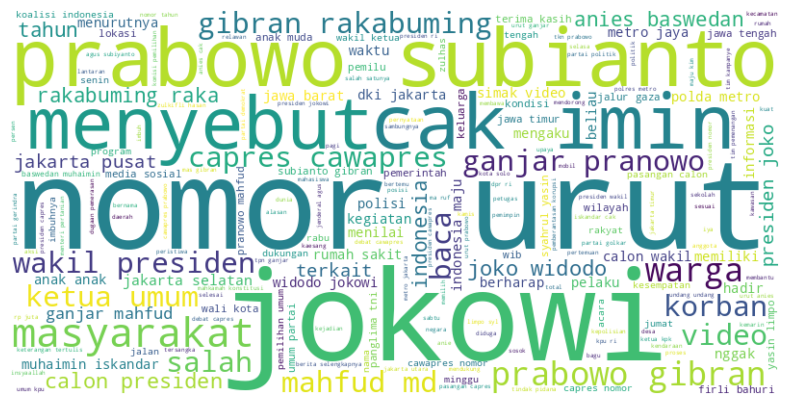

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all texts into one string
all_texts = ' '.join(df['content'])

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_texts)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### LSA

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Membuat vektor TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['content'])

# Membuat model LSA dengan 10 topik
lsa_model = TruncatedSVD(n_components=10)
lsa_topic_matrix = lsa_model.fit_transform(X)

# Menampilkan kata-kata teratas untuk setiap topik
terms = vectorizer.get_feature_names_out()
for i, topic in enumerate(lsa_model.components_):
    top_terms = [terms[j] for j in topic.argsort()[-5:]]
    print(f"Topik {i+1}: {', '.join(top_terms)}")


Topik 1: mahfud, presiden, ganjar, gibran, prabowo
Topik 2: syahrul, bahuri, syl, firli, kpk
Topik 3: serangan, palestina, hamas, gaza, israel
Topik 4: jokowi, subianto, partai, gibran, prabowo
Topik 5: debat, gibran, cak, imin, anies
Topik 6: tni, imin, pelaku, anies, korban
Topik 7: imin, presiden, tni, anies, jokowi
Topik 8: mkmk, putusan, mahkamah, konstitusi, mk
Topik 9: gibran, panglima, agus, debat, tni
Topik 10: kpu, cawapres, presiden, jokowi, debat


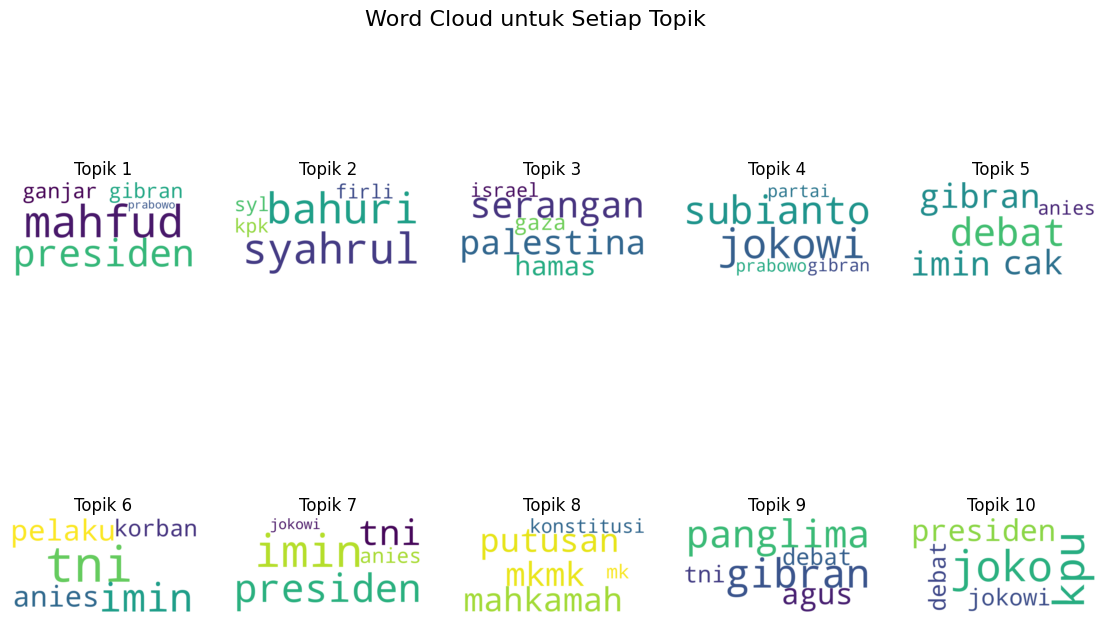

In [12]:
# Membuat model LSA dengan 10 topik
lsa_model = TruncatedSVD(n_components=10)
lsa_topic_matrix = lsa_model.fit_transform(X)

# Mendapatkan kata-kata teratas untuk setiap topik
terms = vectorizer.get_feature_names_out()
top_terms_per_topic = []
for topic in lsa_model.components_:
    top_terms = [terms[j] for j in topic.argsort()[-5:]]
    top_terms_per_topic.append(top_terms)

# Word Cloud
plt.figure(figsize=(14, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(top_terms_per_topic[i]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topik {i+1}')
    plt.axis('off')
plt.suptitle('Word Cloud untuk Setiap Topik', fontsize=16)
plt.show()

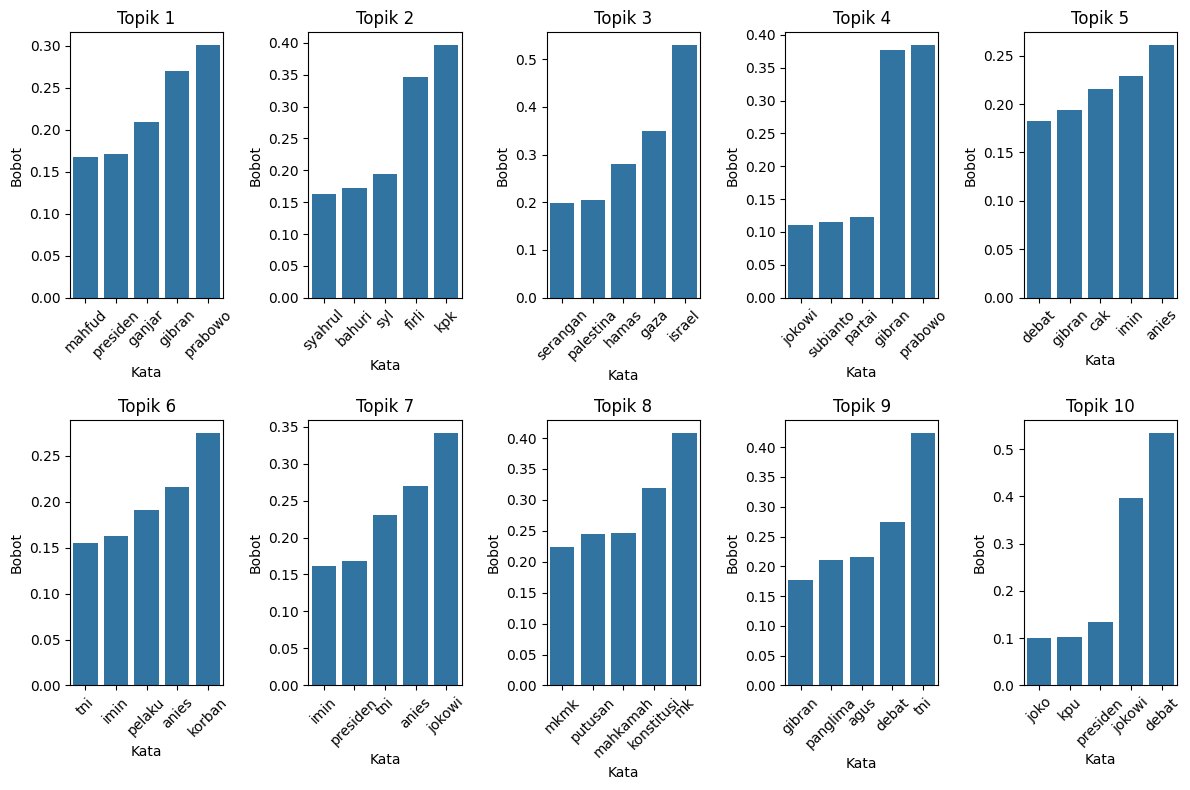

In [13]:
import seaborn as sns
# Bar Plot Topik Kata untuk LSA
plt.figure(figsize=(12, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    top_terms = [terms[j] for j in lsa_model.components_[i].argsort()[-5:]]
    top_weights = sorted(lsa_model.components_[i])[-5:]
    sns.barplot(x=top_terms, y=top_weights)
    plt.title(f'Topik {i+1}')
    plt.xlabel('Kata')
    plt.ylabel('Bobot')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Model Naiye Bayes

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

In [15]:
# Define function to train and evaluate Naive Bayes classifier
def train_and_evaluate(classifier, train_features, train_labels, test_features, test_labels):
    # Train the classifier
    classifier.fit(train_features, train_labels)
    
    # Predictions
    predictions = classifier.predict(test_features)
    
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predictions)
    
    # Calculate F1 score
    f1 = f1_score(test_labels, predictions, average='weighted')
    
    return accuracy, f1

#### Tanpa Parameter

In [16]:
# Initialize Naive Bayes classifier
model_naiye_tanpa_parameter = MultinomialNB()

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_naiye_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_naiye_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_naiye_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 78.55750487329435
TF-IDF Vectorization F1 Score: 78.43827897989584
Bag of Words (BoW) Accuracy: 79.06432748538012
Bag of Words (BoW) F1 Score: 78.94912083800972
Combined TF-IDF and BoW Accuracy: 78.28460038986354
Combined TF-IDF and BoW F1 Score: 78.16429568538739


#### Pakai Parameter

In [17]:
# Initialize Naive Bayes classifier
model_naiye_parameter = MultinomialNB(alpha= 0.1,fit_prior=True)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_naiye_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_naiye_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_naiye_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 81.01364522417154
TF-IDF Vectorization F1 Score: 80.93181664323184
Bag of Words (BoW) Accuracy: 81.24756335282652
Bag of Words (BoW) F1 Score: 81.16643942699937
Combined TF-IDF and BoW Accuracy: 81.28654970760235
Combined TF-IDF and BoW F1 Score: 81.21455160079856


## Model SVM

In [18]:
from sklearn.svm import SVC

#### Tanpa Parameter Sederhana

In [19]:
# Initialize SVM
model_svm_tanpa_parameter =  SVC(kernel='linear', random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_svm_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_svm_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_svm_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 88.46003898635477
TF-IDF Vectorization F1 Score: 88.4637977523376
Bag of Words (BoW) Accuracy: 88.26510721247564
Bag of Words (BoW) F1 Score: 88.25701191936416
Combined TF-IDF and BoW Accuracy: 89.08382066276803
Combined TF-IDF and BoW F1 Score: 89.08986003807136


#### Pakai Parameter

In [20]:
# Initialize SVM
model_svm_parameter =  SVC(C=100, gamma=0.1, kernel='linear')

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_svm_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_svm_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_svm_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 88.73294346978557
TF-IDF Vectorization F1 Score: 88.74970975831613
Bag of Words (BoW) Accuracy: 87.7972709551657
Bag of Words (BoW) F1 Score: 87.79842559070887
Combined TF-IDF and BoW Accuracy: 88.73294346978557
Combined TF-IDF and BoW F1 Score: 88.74340755109337


## Model Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression


#### Tanpa Parameter

In [22]:
# Initialize Naive Bayes classifier
model_lr_tanpa_parameter = LogisticRegression(random_state=42,max_iter=1000)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_lr_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_lr_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_lr_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 85.49707602339181
TF-IDF Vectorization F1 Score: 85.48119123689443
Bag of Words (BoW) Accuracy: 86.62768031189084
Bag of Words (BoW) F1 Score: 86.615244026869
Combined TF-IDF and BoW Accuracy: 87.21247563352826
Combined TF-IDF and BoW F1 Score: 87.20867616270147


#### Parameter

In [23]:
# Initialize Naive Bayes classifier
model_lr_parameter = LogisticRegression(C=5.0, max_iter=1000, penalty='l1', solver='liblinear')

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_lr_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_lr_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_lr_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 87.36842105263159
TF-IDF Vectorization F1 Score: 87.37173197522036
Bag of Words (BoW) Accuracy: 87.29044834307992
Bag of Words (BoW) F1 Score: 87.28467430160032
Combined TF-IDF and BoW Accuracy: 87.21247563352826
Combined TF-IDF and BoW F1 Score: 87.20903476058676


## Model Random Forest 

In [24]:
from sklearn.ensemble import RandomForestClassifier

#### Tanpa Parameter

In [25]:
# Initialize SVM
model_rfc_tanpa_parameter =  RandomForestClassifier(random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_rfc_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_rfc_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_rfc_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 83.66471734892788
TF-IDF Vectorization F1 Score: 83.38681057599331
Bag of Words (BoW) Accuracy: 84.48343079922027
Bag of Words (BoW) F1 Score: 84.24945405486548
Combined TF-IDF and BoW Accuracy: 84.21052631578947
Combined TF-IDF and BoW F1 Score: 83.97081085558781


#### Parameter

In [26]:
# Initialize SVM
model_rfc_parameter =  RandomForestClassifier(min_samples_split=10,min_samples_leaf=2,n_estimators=150,random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_rfc_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_rfc_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_rfc_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 83.27485380116958
TF-IDF Vectorization F1 Score: 83.01544068938497
Bag of Words (BoW) Accuracy: 84.48343079922027
Bag of Words (BoW) F1 Score: 84.30758463389174
Combined TF-IDF and BoW Accuracy: 84.01559454191033
Combined TF-IDF and BoW F1 Score: 83.800422392209


## Model Ensemble Learning

In [27]:
# Mengambil model terbaik dari hasil tuning
best_model_naive_bayes = model_naiye_parameter
best_model_svm = model_svm_parameter
best_model_random_forest = model_rfc_parameter
best_model_logistic_regression = model_lr_parameter

In [28]:
from sklearn.ensemble import VotingClassifier

#### 4 Model

In [29]:
# # Membuat model ensemble
# ensemble_model = VotingClassifier(estimators=[
#     ('naive_bayes', best_model_naive_bayes),
#     ('svm', best_model_svm),
#     ('random_forest', best_model_random_forest),
#     ('logistic_regression', best_model_logistic_regression)
# ], voting='hard')

In [30]:
# # Train and evaluate on TF-IDF Vectorization
# tfidf_accuracy, tfidf_f1 = train_and_evaluate(ensemble_model , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# # Train and evaluate on Bag of Words (BoW) features
# bow_accuracy, bow_f1 = train_and_evaluate(ensemble_model , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# # Train and evaluate on Combined TF-IDF and BoW features
# combined_accuracy, combined_f1 = train_and_evaluate(ensemble_model , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# # Print results
# print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
# print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
# print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
# print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
# print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
# print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

#### 3 Model

In [31]:
# ensemble_model_3 = VotingClassifier(estimators=[
#     ('svm', best_model_svm),
#     ('random_forest', best_model_random_forest),
#     ('logistic_regression', best_model_logistic_regression)
# ], voting='hard')

In [32]:
# # Train and evaluate on TF-IDF Vectorization
# tfidf_accuracy, tfidf_f1 = train_and_evaluate(ensemble_model_3 , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# # Train and evaluate on Bag of Words (BoW) features
# bow_accuracy, bow_f1 = train_and_evaluate(ensemble_model_3 , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# # Train and evaluate on Combined TF-IDF and BoW features
# combined_accuracy, combined_f1 = train_and_evaluate(ensemble_model_3 , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# # Print results
# print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
# print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
# print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
# print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
# print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
# print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

#### 2 Model

In [33]:
# ensemble_model_2 = VotingClassifier(estimators=[
#     ('svm', best_model_svm),
#     ('logistic_regression', best_model_logistic_regression)
# ], voting='hard')

In [34]:
# # Train and evaluate on TF-IDF Vectorization
# tfidf_accuracy, tfidf_f1 = train_and_evaluate(ensemble_model_2 , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# # Train and evaluate on Bag of Words (BoW) features
# bow_accuracy, bow_f1 = train_and_evaluate(ensemble_model_2, count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# # Train and evaluate on Combined TF-IDF and BoW features
# combined_accuracy, combined_f1 = train_and_evaluate(ensemble_model_2, combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# # Print results
# print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
# print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
# print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
# print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
# print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
# print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)